In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from gammapy.modeling.models.cube import IRFModel
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : HlK1Y28W 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 540251.66
  Predicted background counts     : 533641.14
  Predicted excess counts         : 6610.53

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2295232.24

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 13

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal m

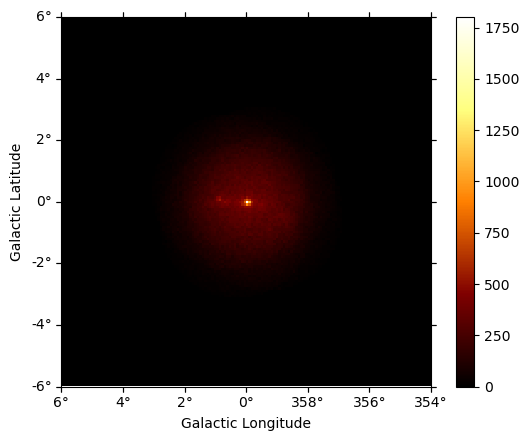

In [3]:
source = 'Galactic Centre'
path = 'C:/Users/yt02izug/Downloads'

dataset_standard = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
#dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models.remove('1745')
models.remove('1746')

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
diff.parameters['tilt'].frozen = False
models.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models


dataset_standard.models[0].parameters['lon_0'].min = dataset_standard.models[0].parameters['lon_0'].value - 1
dataset_standard.models[0].parameters['lon_0'].max = dataset_standard.models[0].parameters['lon_0'].value + 1
dataset_standard.models[0].parameters['lat_0'].min = dataset_standard.models[0].parameters['lat_0'].value - 1
dataset_standard.models[0].parameters['lat_0'].max = dataset_standard.models[0].parameters['lat_0'].value + 1
dataset_standard.models[1].parameters['lon_0'].min = dataset_standard.models[1].parameters['lon_0'].value - 1
dataset_standard.models[1].parameters['lon_0'].max = dataset_standard.models[1].parameters['lon_0'].value + 1
dataset_standard.models[1].parameters['lat_0'].min = dataset_standard.models[1].parameters['lat_0'].value - 1
dataset_standard.models[1].parameters['lat_0'].max = dataset_standard.models[1].parameters['lat_0'].value + 1
#dataset_standard.models[0].parameters['lon_0'].frozen = True
#dataset_standard.models[0].parameters['lat_0'].frozen = True
#dataset_standard.models[1].parameters['lon_0'].frozen = True
#dataset_standard.models[1].parameters['lat_0'].frozen = True


dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(dataset_standard.models.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models


dataset_standard_N = MapDataset.read(f'{path}/GC_fullsys/GC_fullsys.fits')
models_N = Models.read(f"{path}/nuisance_summary/Eff_area/Galactic Centre/GC_model.yml")
models_N.remove('1745')
models_N.remove('1746')

diff = Map.read(f'{path}/diffusetemplate.fits')
new_geom = diff.geom.rename_axes(['energy'], ['energy_true'])
diff_new = Map.from_geom(geom = new_geom, data = diff.data, unit = diff.unit) 
temp = TemplateSpatialModel(diff_new, normalize=False, filename = f'{path}/diffusetemplate.fits')
diff = SkyModel(spatial_model=temp, name = 'diff', spectral_model = PowerLawNormSpectralModel())
diff.parameters['tilt'].frozen = False
models_N.append(diff)
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard_N.name)
bkg_model.parameters['tilt'].frozen  = False
models_N.append(bkg_model)
#irf model
IRFmodel = IRFModel(dataset_name = dataset_standard_N.name)
IRFmodel.parameters['bias'].frozen  = True
IRFmodel.parameters['resolution'].frozen  = True
IRFmodel.parameters['tilt_nuisance'].frozen  = False
models_N.append(IRFmodel)
dataset_standard_N.models = models_N
#dataset_standard_N.models.parameters['norm_nuisance'].value  = 0.0
#dataset_standard_N.models.parameters['tilt_nuisance'].value  = 0.0
#dataset_standard_N.exposure = dataset_standard_N.npred_exposure()
zero = 1e-24
shift = 0.1
tilt = 0.015
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_standard_N.penalising_invcovmatrix = penalising_invcovmatrix


dataset_standard_N.models[0].parameters['lon_0'].min = dataset_standard_N.models[0].parameters['lon_0'].value - 1
dataset_standard_N.models[0].parameters['lon_0'].max = dataset_standard_N.models[0].parameters['lon_0'].value + 1
dataset_standard_N.models[0].parameters['lat_0'].min = dataset_standard_N.models[0].parameters['lat_0'].value - 1
dataset_standard_N.models[0].parameters['lat_0'].max = dataset_standard_N.models[0].parameters['lat_0'].value + 1
dataset_standard_N.models[1].parameters['lon_0'].min = dataset_standard_N.models[1].parameters['lon_0'].value - 1
dataset_standard_N.models[1].parameters['lon_0'].max = dataset_standard_N.models[1].parameters['lon_0'].value + 1
dataset_standard_N.models[1].parameters['lat_0'].min = dataset_standard_N.models[1].parameters['lat_0'].value - 1
dataset_standard_N.models[1].parameters['lat_0'].max = dataset_standard_N.models[1].parameters['lat_0'].value + 1
#dataset_standard_N.models[0].parameters['lon_0'].frozen = True
#dataset_standard_N.models[0].parameters['lat_0'].frozen = True
#dataset_standard_N.models[1].parameters['lon_0'].frozen = True
#dataset_standard_N.models[1].parameters['lat_0'].frozen = True

#Setting Mask J1745-303
j1745_coord = SkyCoord(358.6435538, -0.5617789, unit='deg',frame='galactic')
skyregion_1745 = RectangleSkyRegion(center=j1745_coord, width=1*u.deg,height=1*u.deg)#, angle = 108*u.deg)
geom = dataset_standard.counts.geom
mask_space = ~geom.region_mask([skyregion_1745])
dataset_standard.mask_fit = mask_space
dataset_standard_N.mask_fit = mask_space
    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)
print(dataset_standard_N)
#print(dataset_asimov)

## Single Cases

In [4]:
true_energy = dataset_standard.exposure.geom.axes[0].center.value

shift_neg = 0.10 #-0.085
tilt_neg = 0.015 #-0.015

print(tilt_neg)
datasets = []
datasets_N = []

datasets.append(dataset_standard)

zero = 1e-24
## additional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift_neg**2, 1/tilt_neg**2, 1/zero**2, 1/zero**2])
dataset_standard_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets_N.append(dataset_standard_N)

0.015


In [5]:
#%%time
fit = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit.backend = "minuit"
fit.optimize_opts = minuit_opts
result = fit.run([datasets[0]])

In [6]:
#%%time
fit_N = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_N.backend = "minuit"
fit_N.optimize_opts = minuit_opts
result_N = fit_N.run([datasets_N[0]])

In [7]:
print(datasets[0])

MapDataset
----------

  Name                            : HlK1Y28W 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 591507.16
  Predicted background counts     : 574454.15
  Predicted excess counts         : 17053.01

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2303819.10

  Number of models                : 4 
  Number of parameters            : 18
  Number of free parameters       : 13

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parame

In [8]:
print(datasets_N[0])

MapDataset
----------

  Name                            : bQOMYoVy 

  Total counts                    : 596011 
  Total background counts         : 533641.19
  Total excess counts             : 62369.81

  Predicted counts                : 591508.77
  Predicted background counts     : 574455.40
  Predicted excess counts         : 17053.37

  Exposure min                    : 5.70e+01 m2 s
  Exposure max                    : 1.54e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 97420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -2303819.35

  Number of models                : 5 
  Number of parameters            : 23
  Number of free parameters       : 15

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parame

# Stat Profiles

In [9]:
import upper_limit_18_02

## Stat Profiles for BKG Norm

In [10]:
def make_writable(stat):
    write = dict()
    for k in stat.keys():
        if k != 'fit_results':
            write[k] = [float(i) for i in stat[k]]
            
                
    return write

In [11]:
datasets_N[0].models[-2].parameters['norm']

Parameter(name='norm', value=1.0571048819427318, factor=1.0571048819427318, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, id=0x168810031c0, is_penalised=False)

In [12]:
#%%time
computing_norm = True

if computing_norm :
    parameter = datasets[0].models[-1].parameters['norm']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile = fit.stat_profile([datasets[0]], parameter, reoptimize= True)
    stat_profile['scale_scan'] = stat_profile.pop(next(iter(stat_profile)) )    
    with open('data/5b_scan_norm.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile), file)
else:
    with open('data/5b_scan_norm.yaml') as file:
        stat_profile = yaml.load( file, Loader=yaml.FullLoader)   

In [13]:
#%%time
if computing_norm :
    parameter = datasets_N[0].models[-2].parameters['norm']
    sigma = 3
    parameter.scan_n_sigma  = sigma
    stat_profile_N = fit.stat_profile([datasets_N[0]], parameter, reoptimize = True)
    stat_profile_N['scale_scan'] = stat_profile_N.pop(next(iter(stat_profile_N)) )    
    with open('data/5b_scan_norm_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N), file)
    for k in stat_profile_N:
        if "spectral" in k:
            key_name = "scale_scan"
            stat_profile_N[key_name] = stat_profile_N[k]      
else:
    with open('data/5b_scan_norm_N.yaml') as file:
        stat_profile_N = yaml.load( file, Loader=yaml.FullLoader)
    

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid val

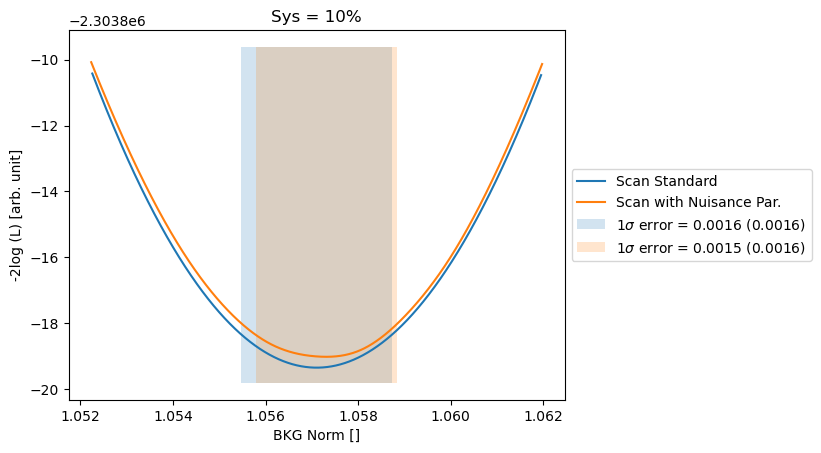

In [14]:
fig = plt.figure()
ll_N = stat_profile_N.copy()
ul_N = upper_limit_18_02.upper_limit(ll_N,0,0)
L_N, x_N = ul_N.interpolate()
plt.plot(x_N, L_N(x_N),label ="Scan Standard")

ll = stat_profile.copy()
ul = upper_limit_18_02.upper_limit(ll,0,0)
L, x = ul.interpolate()
plt.plot(x, L(x),label ="Scan with Nuisance Par.")

norm_err_N = datasets_N[0].background_model.parameters['norm'].error
norm_err = datasets[0].background_model.parameters['norm'].error


min_, er = ul_N.likelihood_error()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err_N:.2})')
min_, er, upp = ul.likelihood_upper()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ error = {er:.2} ({norm_err:.2})')

plt.xlabel("BKG Norm []")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(ylim[0], ylim[1]-4)
plt.title("Sys = 10%")

fig.savefig("plots/5b_stat_scan_norm.pdf")

## Stat Profiles for Source Signal

In [11]:
#%%time
computing_amplitude = False

if computing_amplitude:
    sigma = 3
    parameter_a = datasets[0].models[0].parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open('data/5b_scan_amplitude.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)
    
else:
    with open('data/5b_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [12]:
#%%time
computing_amplitude_N = False
if computing_amplitude_N:
    sigma = 1.5 #3
    parameter_a = datasets_N[0].models[0].parameters['amplitude']
    parameter_a.scan_n_sigma = sigma
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    
    
    with open('data/5b_scan_amplitude_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)
    
else:
    with open('data/5b_scan_amplitude_N.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)

    
    

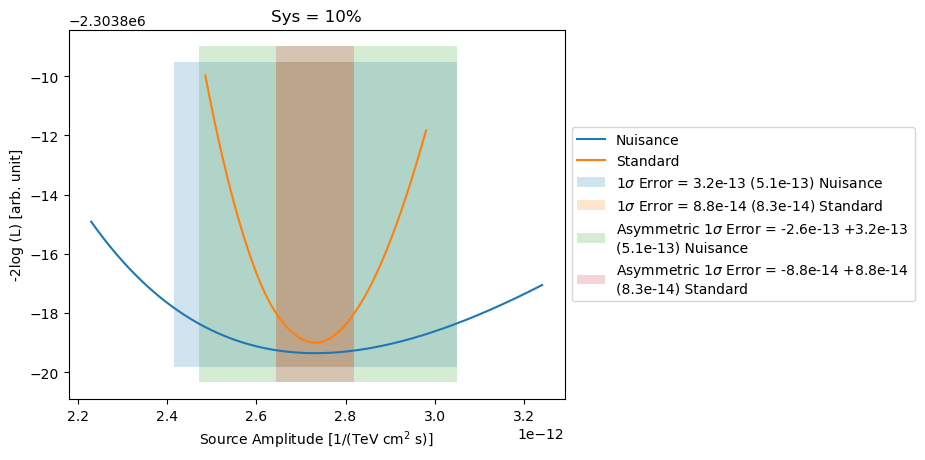

In [17]:
fig = plt.figure()
ll_N_a = stat_profile_N_a.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_a.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "Standard")

amplitude_err = datasets[0].models[0].parameters['amplitude'].error
amplitude_err_N = datasets_N[0].models[0].parameters['amplitude'].error



min_, er = ul_N_a.likelihood_error()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ Error = {er:.2} ({amplitude_err_N:.2}) Nuisance')
min_, er = ul_a.likelihood_error()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ Error = {er:.2} ({amplitude_err:.2}) Standard')

min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, 
                label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2}) Nuisance')
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2}) Standard')

plt.xlabel("Source Amplitude [1/(TeV cm$^2$ s)]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")

fig.savefig("plots/5b_stat_scan_amplitude.pdf")

## Stat Profiles for Source Index

In [11]:
#%%time
computing_index = False

if computing_index:
    sigma = 3
    parameter_i = datasets[0].models[0].parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_i = fit.stat_profile([datasets[0]], parameter_i, reoptimize= True)
    stat_profile_i['scale_scan'] = stat_profile_i.pop(next(iter(stat_profile_i)) )    
    with open('data/5_scan_index.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_i), file)
    
else:
    with open('data/5b_scan_index.yaml') as file:
        stat_profile_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

In [12]:
#%%time
computing_index_N = False
if computing_index_N:
    sigma = 3
    parameter_i = datasets_N[0].models[0].parameters['index']
    parameter_i.scan_n_sigma = sigma
    stat_profile_N_i = fit.stat_profile([datasets_N[0]], parameter_i, reoptimize = True)
    stat_profile_N_i['scale_scan'] = stat_profile_N_i.pop(next(iter(stat_profile_N_i)) )    
    
    with open('data/5b_scan_index_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_i), file)
    
else:
    with open('data/5b_scan_index_N.yaml') as file:
        stat_profile_N_i = yaml.load( file, Loader=yaml.FullLoader)

    
    

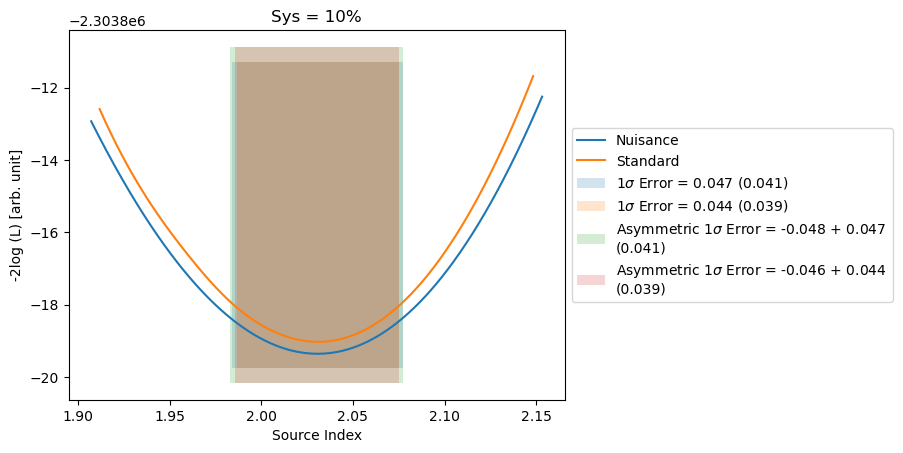

In [13]:
fig = plt.figure()
ll_N_a = stat_profile_N_i.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")


ll_a = stat_profile_i.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "Standard")

index_err = datasets[0].models[0].parameters['index'].error
index_err_N = datasets_N[0].models[0].parameters['index'].error



min_, er = ul_N_a.likelihood_error()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ Error = {er:.2} ({index_err_N:.2})')
min_, er = ul_a.likelihood_error()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ Error = {er:.2} ({index_err:.2})')

min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, 
                label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} + {er_pos:.2} \n({index_err_N:.2})')
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} + {er_pos:.2} \n({index_err:.2})')

plt.xlabel("Source Index")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")

fig.savefig("plots/5b_stat_scan_index.pdf")

## Stat Profiles for Source Lambda

In [22]:
scan_array = np.append(np.linspace(0.01, 0.4, 11), datasets[0].models[0].parameters['lambda_'].value)
print(scan_array)

[0.01      0.049     0.088     0.127     0.166     0.205     0.244
 0.283     0.322     0.361     0.4       0.0887451]


In [12]:
#%%time
computing_lambda = True

if computing_lambda:
    sigma = 3
    scan_array = np.append(np.linspace(0.01, 0.5, 11), datasets[0].models[0].parameters['lambda_'].value)
    scan_array.sort()
    parameter_l = datasets[0].models[0].parameters['lambda_']
    parameter_l.scan_values = scan_array#scan_n_sigma = sigma
    stat_profile_l = fit.stat_profile([datasets[0]], parameter_l, reoptimize= True)
    stat_profile_l['scale_scan'] = stat_profile_l.pop(next(iter(stat_profile_l)) )    
    with open('data/5b_scan_lambda.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_l), file)
    
else:
    with open('data/5b_scan_lambda.yaml') as file:
        stat_profile_l = yaml.load( file, Loader=yaml.FullLoader)

In [23]:
#%%time
computing_lambda_N = True
if computing_lambda_N:
    sigma = 3
    scan_array = np.append(np.linspace(0.01, 0.5, 11), datasets_N[0].models[0].parameters['lambda_'].value)
    scan_array.sort()
    parameter_l = datasets_N[0].models[0].parameters['lambda_']
    parameter_l.scan_values = scan_array#scan_n_sigma = sigma
    stat_profile_N_l = fit.stat_profile([datasets_N[0]], parameter_l, reoptimize = True)
    stat_profile_N_l['scale_scan'] = stat_profile_N_l.pop(next(iter(stat_profile_N_l)) )    
    
    with open('data/5b_scan_lambda_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_l), file)
    
else:
    with open('data/5b_scan_lambda_N.yaml') as file:
        stat_profile_N_l = yaml.load( file, Loader=yaml.FullLoader)

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow enco

Position <SkyCoord (Galactic): (l, b) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (Galactic): (l, b) in deg
    (nan, nan)> is outside valid IRF map range, using nearest IRF defined

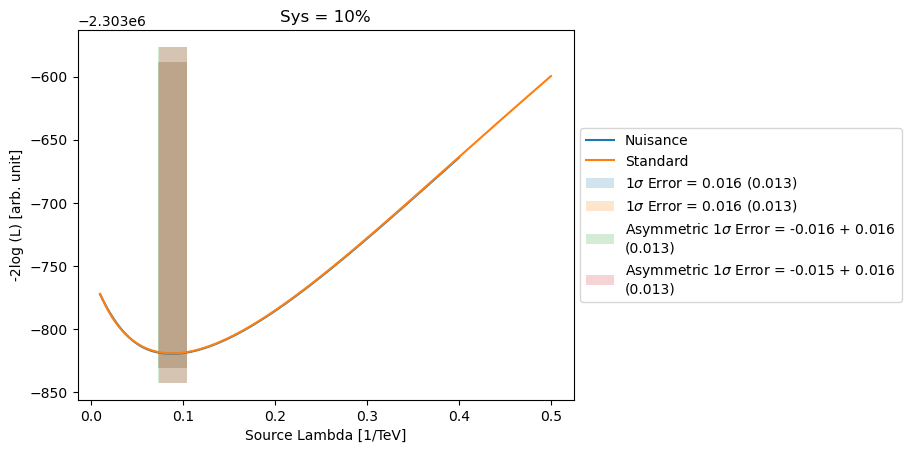

In [25]:
fig = plt.figure()
with open(f'data/5b_scan_lambda_N.yaml') as file:
            stat_profile_N_l = yaml.load( file, Loader=yaml.FullLoader)
ll_N_a = stat_profile_N_l.copy()
ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0)
L_N_a, x_N_a = ul_N_a.interpolate()
plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance")

with open(f'data/5b_scan_lambda.yaml') as file:
            stat_profile_l = yaml.load( file, Loader=yaml.FullLoader)
ll_a = stat_profile_l.copy()
ul_a = upper_limit_18_02.upper_limit(ll_a,0,0)
L_a, x_a = ul_a.interpolate()
plt.plot(x_a, L_a(x_a),label = "Standard")

lambda_err = datasets[0].models[0].parameters['lambda_'].error
lambda_err_N = datasets_N[0].models[0].parameters['lambda_'].error



min_, er = ul_N_a.likelihood_error()
min_ = min_[0]; er = er[0]
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1], alpha = 0.2, 
                label = f'1$\sigma$ Error = {er:.2} ({lambda_err_N:.2})')
min_, er = ul_a.likelihood_error()
min_ = min_[0]; er = er[0]
ax.fill_between(  [min_-er, min_+ er], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'1$\sigma$ Error = {er:.2} ({lambda_err:.2})')

min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax = plt.gca()
ylim= ax.get_ylim()
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, 
                label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} + {er_pos:.2} \n({lambda_err_N:.2})')
min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, 
                label = f'Asymmetric 1$\sigma$ Error = -{er_neg:.2} + {er_pos:.2} \n({lambda_err:.2})')

plt.xlabel("Source Lambda [1/TeV]")
plt.ylabel("-2log (L) [arb. unit]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(ylim[0], ylim[1]-25)
plt.title("Sys = 10%")

fig.savefig("plots/5b_stat_scan_lambda.pdf")

## Penalty Examples

In [ ]:
ps = [1e-2, 0.05, 0.1]
plot_values = np.linspace(-0.1, 0.1, 100)
for p in ps:
    plt.plot(plot_values, plot_values ** 2 / p ** 2, label = "$\sigma$ = "+ str(p)) 
plt.legend()

plt.ylabel('Penalty on Likelihood')    
plt.xlabel('Eff. Area Parameter')
fig  = plt.gcf()
fig.savefig('plots/5_gaussian_penalty_example.pdf')

## Computing Delta TS

In [37]:
#%%time
computing_amplitude = True

if computing_amplitude:
    sigma = 3
    parameter_a = datasets[0].models[0].parameters['amplitude']
    parameter_a.scan_values = [0.0]
    stat_profile_a = fit.stat_profile([datasets[0]], parameter_a, reoptimize= True)
    stat_profile_a['scale_scan'] = stat_profile_a.pop(next(iter(stat_profile_a)) )    
    with open(f'data/5b_scan_amplitude_at_zero.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_a), file)


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

In [38]:
#%%time
computing_amplitude_N = True

if computing_amplitude_N:
    sigma = 3
    parameter_a = datasets_N[0].models[0].parameters['amplitude']
    parameter_a.scan_values = [0.0]
    stat_profile_N_a = fit.stat_profile([datasets_N[0]], parameter_a, reoptimize = True)
    stat_profile_N_a['scale_scan'] = stat_profile_N_a.pop(next(iter(stat_profile_N_a)) )    

    with open(f'data/5b_scan_amplitude_at_zero_N.yaml', 'w') as file:
        documents = yaml.dump(make_writable(stat_profile_N_a), file)

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow enco

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow enco

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

In [39]:
from numpy import savetxt
with open(f'data/5b_scan_amplitude_at_zero.yaml') as file:
            stat_profile_a_0 = yaml.load( file, Loader=yaml.FullLoader)
with open(f'data/5b_scan_amplitude.yaml') as file:
        stat_profile_a = yaml.load( file, Loader=yaml.FullLoader)
#print(min(stat_profile_a['stat_scan']))
b = min(stat_profile_a_0['stat_scan']) - min(stat_profile_a['stat_scan'])
print(np.sqrt(b))
np.savetxt('data/5b_significance.txt', [np.sqrt(b)])

19.52486492469118


In [40]:
with open(f'data/5b_scan_amplitude_at_zero_N.yaml') as file:
            stat_profile_N_a_0 = yaml.load( file, Loader=yaml.FullLoader)
with open(f'data/5b_scan_amplitude_N.yaml') as file:
        stat_profile_N_a = yaml.load( file, Loader=yaml.FullLoader)
#print(min(stat_profile_a['stat_scan']))
b = min(stat_profile_N_a_0['stat_scan']) - min(stat_profile_N_a['stat_scan'])
print(np.sqrt(b))
np.savetxt(f'data/5b_significance_N.txt', [np.sqrt(b)])

61.05216858369584
